In [ ]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Define data paths
data_paths = {
    'Assamese': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\assamese_female_english\english\wav',
    'Bengali': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\bengali_female_english\english\wav',
    'Gujrati': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\gujrati_female_english\english\wav',
    'Kannada': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\kannada_female_english\english\wav',
    'Malayalam': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\malayalam_female_english\english\wav',
    'Marathi': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\marathi_female_english\english\wav',
    'Rajasthani': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\rajasthani_female_english\english\wav',
    'Telugu': r'F:\ACCENT_SPEECH_RECOGNITION\DataBase\telugu_female_english\english\wav'
}


In [5]:
# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    
    # Extracting various features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    
    # Aggregating features into a single vector
    features = np.hstack((
        np.mean(mfccs, axis=1),
        np.mean(chroma, axis=1),
        np.mean(spectral_contrast, axis=1)
    ))
    
    return features


In [6]:
# Initialize list to store data and labels
data = []
labels = []

# Process each directory (language)
for accent, path in data_paths.items():
    print(f'Processing {accent} accent...')
    
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        
        # Extract features
        features = extract_features(file_path)
        
        # Append data and corresponding label
        data.append(features)
        labels.append(accent)

# Convert data and labels to a DataFrame for analysis
df = pd.DataFrame(data)
df['label'] = labels

# Display the first few rows of the DataFrame
df.head()


Processing Assamese accent...
Processing Bengali accent...
Processing Gujrati accent...
Processing Kannada accent...
Processing Malayalam accent...
Processing Marathi accent...
Processing Rajasthani accent...
Processing Telugu accent...


,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,label
0,-488.405182,95.685730,-15.043471,23.136152,0.726868,0.609951,-11.612423,6.855276,-2.606480,-12.396372,...,0.387357,0.432614,10.053970,19.663407,19.005662,19.187684,19.666625,21.125072,23.233353,Assamese
1,-485.650391,88.755997,-22.873020,27.381882,17.412971,19.481659,-21.832827,-3.832956,-3.411139,-14.818323,...,0.440384,0.441187,10.458477,18.450607,19.808771,18.008077,20.560302,21.960636,23.437298,Assamese
2,-514.132202,76.650970,-22.340563,30.972141,20.469595,11.886643,-16.408375,3.773536,0.163655,-10.074533,...,0.432977,0.389454,9.875470,17.933740,18.384542,17.815590,20.489515,21.270920,22.197593,Assamese
3,-510.667572,85.421669,-17.975302,29.948977,25.639090,4.846275,-18.467871,3.688144,-0.953530,-15.075835,...,0.444372,0.451574,10.364607,18.712175,19.464584,19.070180,21.748705,22.731187,21.636462,Assamese
4,-515.804688,79.441513,-31.971291,29.100092,17.503607,16.803137,-12.588396,-3.470878,-6.698751,-7.980804,...,0.412499,0.477854,9.849381,16.831169,16.575864,16.695404,19.526553,20.029130,22.457678,Assamese


Summary Statistics:
                 0             1             2             3             4   \
count  40879.000000  40879.000000  40879.000000  40879.000000  40879.000000   
mean    -406.698096     98.948676     -4.121404     23.362968     10.893227   
std       61.600960     18.039164     10.482335     10.005295      8.822981   
min     -690.948914     43.200844    -49.075039     -9.144279    -23.197521   
25%     -453.274307     84.715302    -11.249033     16.156018      5.055784   
50%     -398.568512     98.231583     -4.483678     22.453821     10.827764   
75%     -351.843277    112.356915      2.791356     29.305060     16.808376   
max     -260.259399    165.398239     34.508503     73.565247     46.548878   

                 5             6             7             8             9   \
count  40879.000000  40879.000000  40879.000000  40879.000000  40879.000000   
mean       7.356578     -7.401314      1.529969     -1.943451     -8.924490   
std        6.656094      6.7678

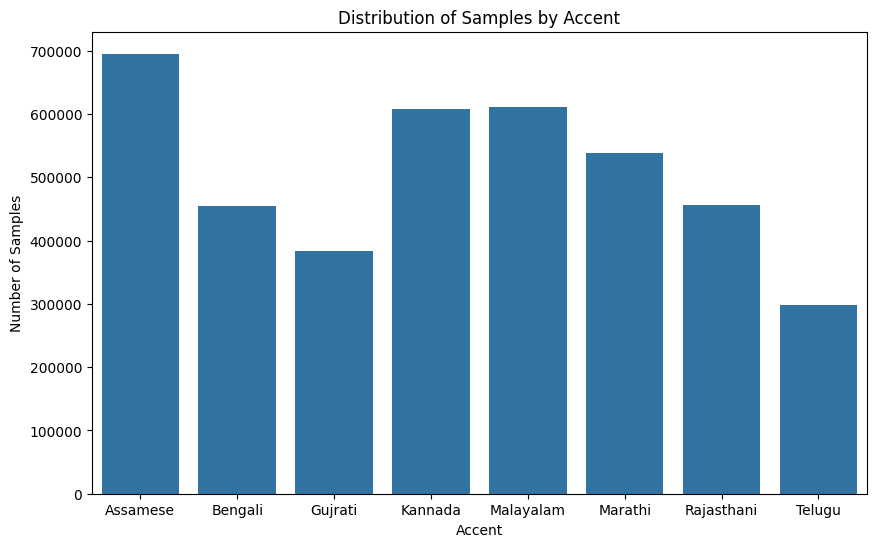

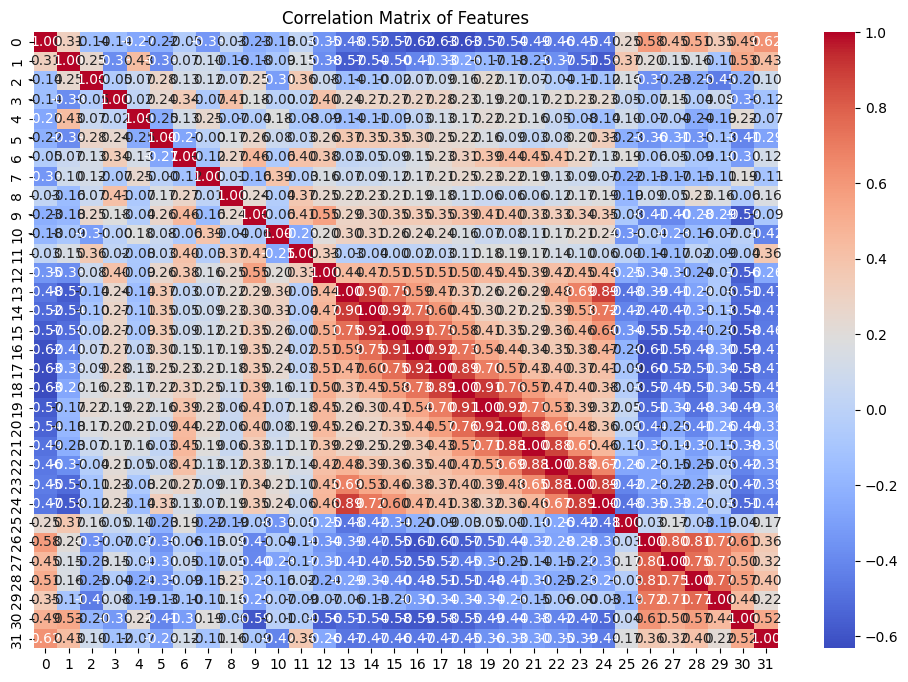

In [7]:
# 1. Summary Statistics
print("Summary Statistics:")
print(df.describe())

# 2. Distribution of Accents
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Samples by Accent')
plt.xlabel('Accent')
plt.ylabel('Number of Samples')
plt.show()

# 3. Correlation Matrix
# Drop non-numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=[float, int])
plt.figure(figsize=(12, 8))
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()


In [8]:
# Separate features and labels
X = df.drop(columns=['label'])
y = df['label']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [10]:
# Initialize models
models = {
    'SVM': SVC(probability=True),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss')
}

# Function to evaluate models using cross-validation
def evaluate_model(model_pipeline, X, y, kf):
    fold_accuracies = []
    
    # Stratified k-fold loop
    for fold_idx, (train_index, test_index) in enumerate(kf.split(X, y), 1):
        print(f"\nEvaluating fold {fold_idx}...")
        
        # Split data into training and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Train the model
        model_pipeline.fit(X_train, y_train)

        # Predict on the test set
        y_pred = model_pipeline.predict(X_test)

        # Calculate accuracy for this fold
        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracies.append(accuracy)
        print(f"Accuracy for fold {fold_idx}: {accuracy:.4f}")

        # Print classification report for this fold
        print(f"Classification report for fold {fold_idx}:")
        print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for fold {fold_idx}')
        plt.show()

    # Print mean accuracy across all folds
    mean_accuracy = np.mean(fold_accuracies)
    print(f"\nMean accuracy across all folds: {mean_accuracy:.4f}")



Evaluating SVM model...

Evaluating fold 1...
Accuracy for fold 1: 0.9973
Classification report for fold 1:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      1.00      1.00       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       541
   Malayalam       0.99      0.99      0.99       513
     Marathi       1.00      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       1.00      0.99      1.00       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



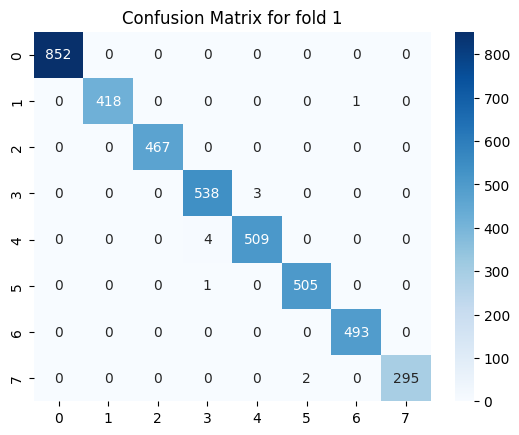


Evaluating fold 2...
Accuracy for fold 2: 0.9961
Classification report for fold 2:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      1.00      1.00       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      1.00      0.99       541
   Malayalam       1.00      0.99      0.99       513
     Marathi       1.00      0.99      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      1.00      0.99       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



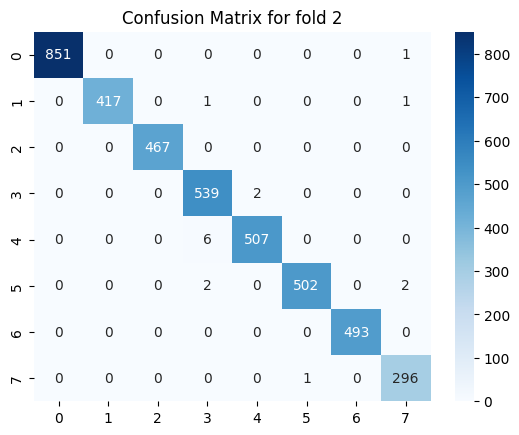


Evaluating fold 3...
Accuracy for fold 3: 0.9963
Classification report for fold 3:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      1.00      1.00       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       1.00      0.99      0.99       541
   Malayalam       0.99      1.00      1.00       513
     Marathi       0.99      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.99      0.99       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



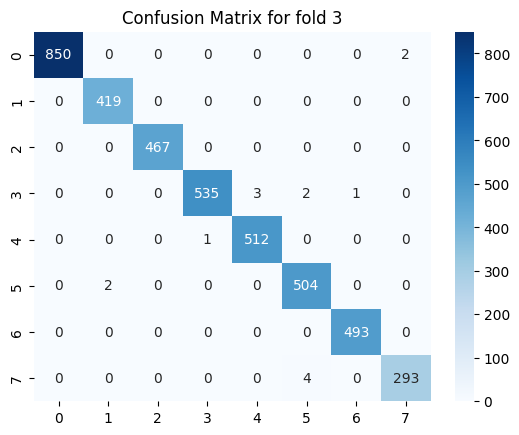


Evaluating fold 4...
Accuracy for fold 4: 0.9973
Classification report for fold 4:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      1.00      0.99       541
   Malayalam       1.00      0.98      0.99       513
     Marathi       1.00      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      1.00      0.99       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



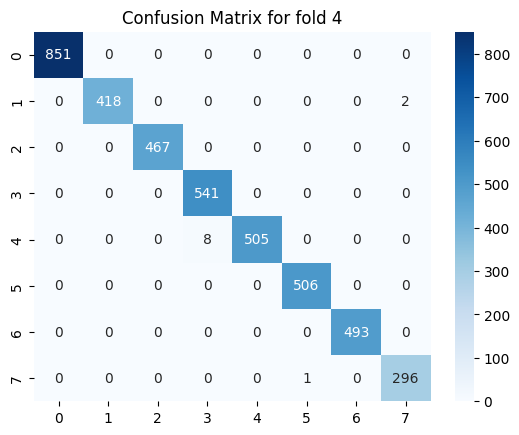


Evaluating fold 5...
Accuracy for fold 5: 0.9971
Classification report for fold 5:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.99      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       541
   Malayalam       0.99      0.99      0.99       513
     Marathi       1.00      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       1.00      1.00      1.00       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



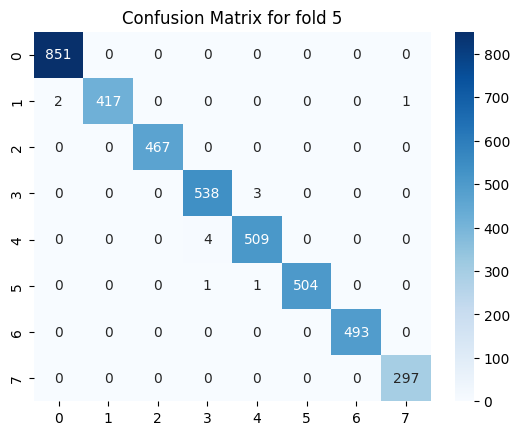


Evaluating fold 6...
Accuracy for fold 6: 0.9968
Classification report for fold 6:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      1.00      0.99       541
   Malayalam       1.00      0.99      0.99       513
     Marathi       0.99      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       1.00      0.99      0.99       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



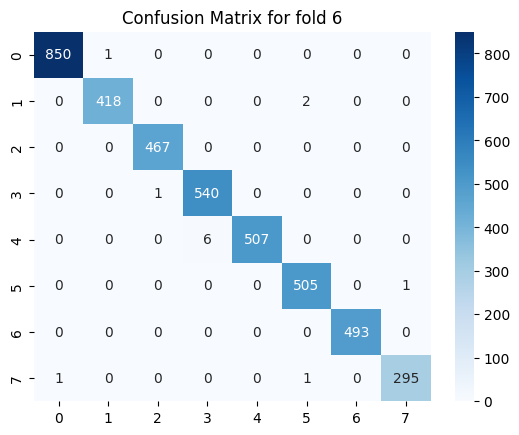


Evaluating fold 7...
Accuracy for fold 7: 0.9976
Classification report for fold 7:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.99      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       1.00      1.00      1.00       540
   Malayalam       0.99      1.00      1.00       514
     Marathi       1.00      0.99      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       1.00      1.00      1.00       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



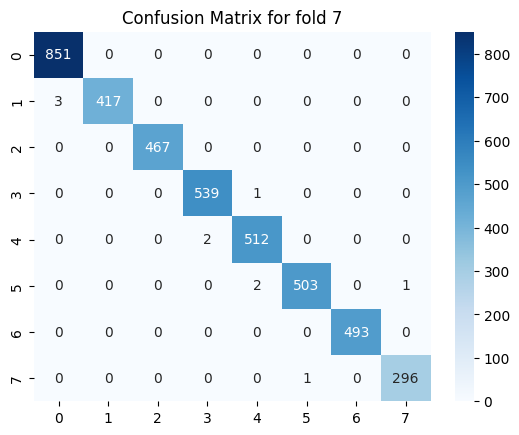


Evaluating fold 8...
Accuracy for fold 8: 0.9966
Classification report for fold 8:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       514
     Marathi       1.00      0.99      1.00       505
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.99      0.99      0.99       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



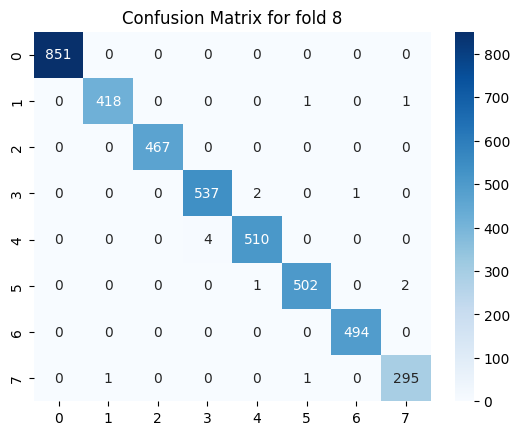


Evaluating fold 9...
Accuracy for fold 9: 0.9968
Classification report for fold 9:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       513
     Marathi       1.00      0.99      1.00       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.99      1.00      1.00       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



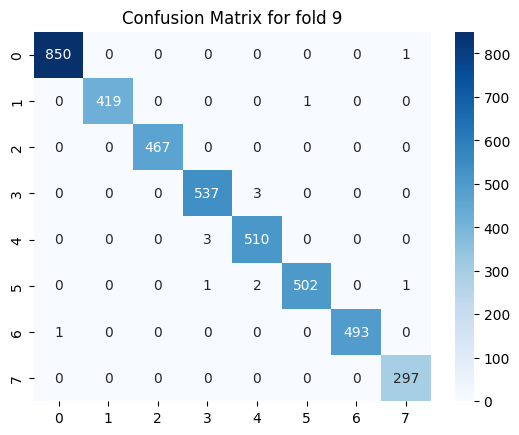


Evaluating fold 10...
Accuracy for fold 10: 0.9966
Classification report for fold 10:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      1.00      0.99       540
   Malayalam       1.00      0.99      1.00       513
     Marathi       0.99      0.99      0.99       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       1.00      0.98      0.99       296

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087



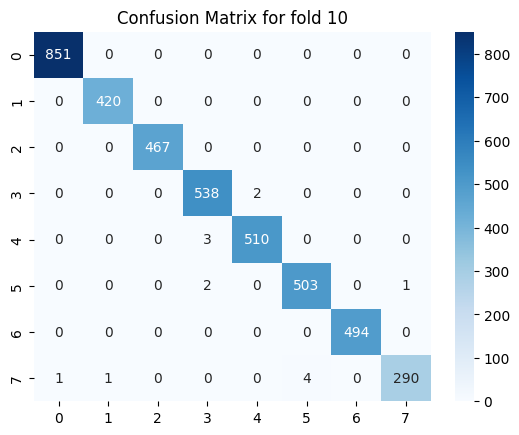


Mean accuracy across all folds: 0.9968

Evaluating Logistic Regression model...

Evaluating fold 1...
Accuracy for fold 1: 0.9795
Classification report for fold 1:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      0.98      0.99       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.98      0.98       541
   Malayalam       0.98      0.98      0.98       513
     Marathi       0.94      0.95      0.94       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.91      0.91      0.91       297

    accuracy                           0.98      4088
   macro avg       0.97      0.97      0.97      4088
weighted avg       0.98      0.98      0.98      4088



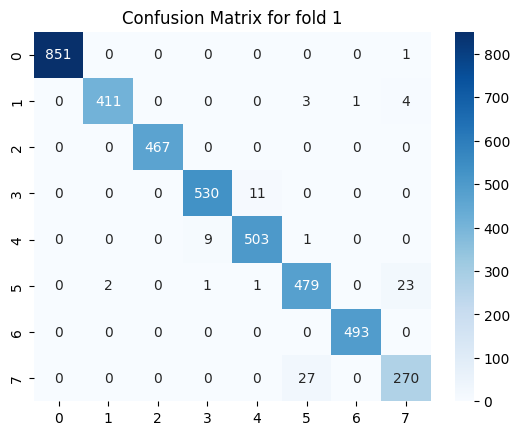


Evaluating fold 2...
Accuracy for fold 2: 0.9804
Classification report for fold 2:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       0.99      0.97      0.98       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.97      0.99      0.98       541
   Malayalam       0.98      0.98      0.98       513
     Marathi       0.96      0.96      0.96       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.90      0.92      0.91       297

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088



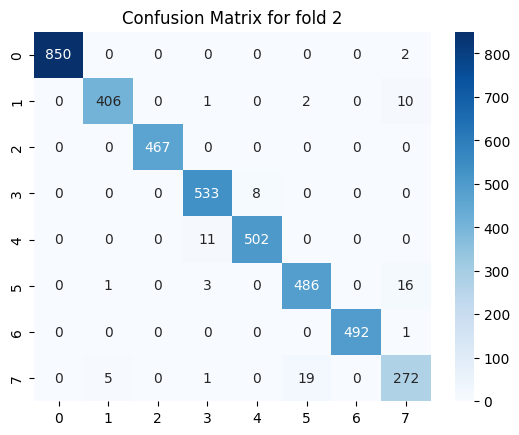


Evaluating fold 3...
Accuracy for fold 3: 0.9831
Classification report for fold 3:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       0.98      0.99      0.98       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.98      0.98       541
   Malayalam       0.98      0.99      0.98       513
     Marathi       0.94      0.97      0.96       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.95      0.91      0.93       297

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088



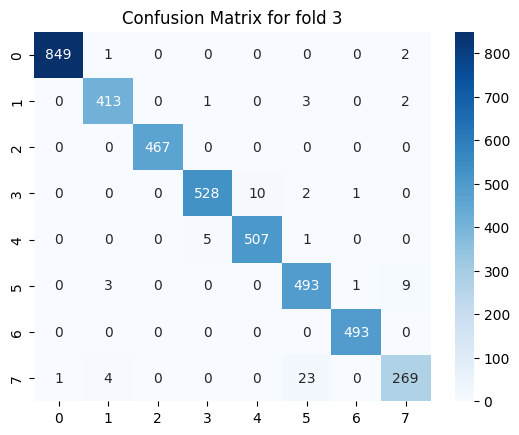


Evaluating fold 4...
Accuracy for fold 4: 0.9817
Classification report for fold 4:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       0.99      0.99      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.99      0.98       541
   Malayalam       0.99      0.97      0.98       513
     Marathi       0.94      0.96      0.95       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.93      0.91      0.92       297

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088



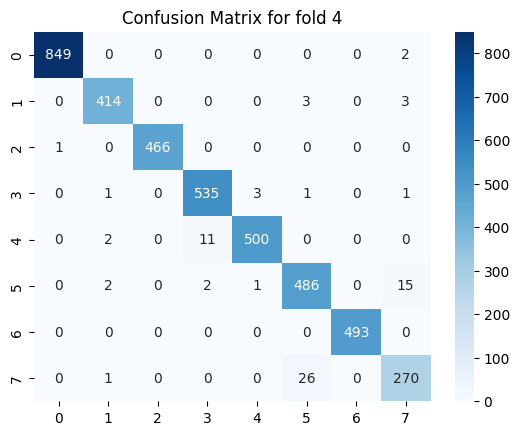


Evaluating fold 5...
Accuracy for fold 5: 0.9807
Classification report for fold 5:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.98      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.98      0.98       541
   Malayalam       0.98      0.97      0.98       513
     Marathi       0.95      0.96      0.95       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.92      0.92      0.92       297

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088



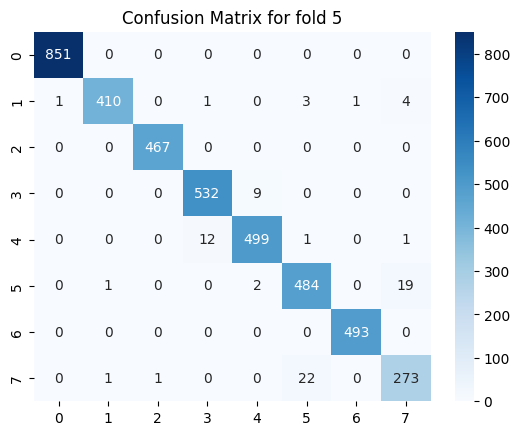


Evaluating fold 6...
Accuracy for fold 6: 0.9843
Classification report for fold 6:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       0.99      0.99      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.99      0.99       541
   Malayalam       1.00      0.98      0.99       513
     Marathi       0.95      0.96      0.96       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.94      0.94      0.94       297

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088



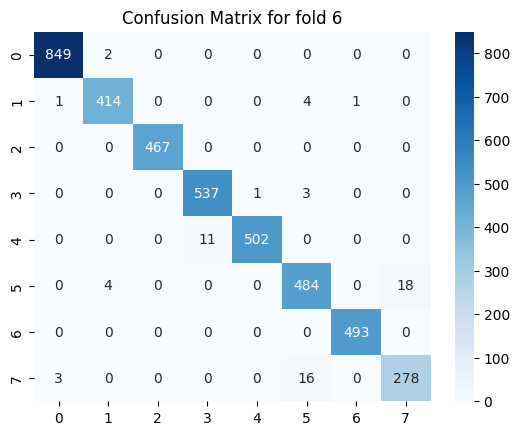


Evaluating fold 7...
Accuracy for fold 7: 0.9773
Classification report for fold 7:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       0.99      0.98      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.97      0.97       540
   Malayalam       0.97      0.98      0.97       514
     Marathi       0.94      0.95      0.95       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.90      0.90      0.90       297

    accuracy                           0.98      4088
   macro avg       0.97      0.97      0.97      4088
weighted avg       0.98      0.98      0.98      4088



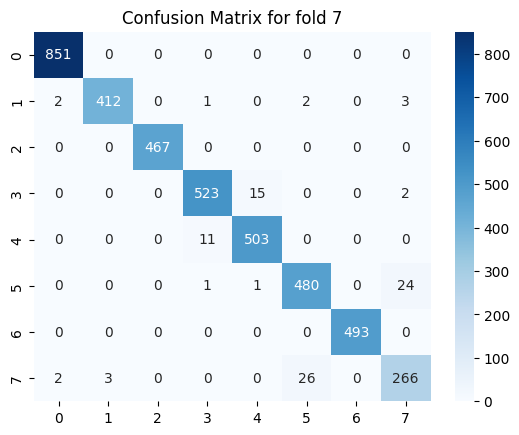


Evaluating fold 8...
Accuracy for fold 8: 0.9839
Classification report for fold 8:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       0.99      0.98      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.98      0.98       540
   Malayalam       0.98      0.98      0.98       514
     Marathi       0.96      0.97      0.96       505
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.93      0.94      0.93       297

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088



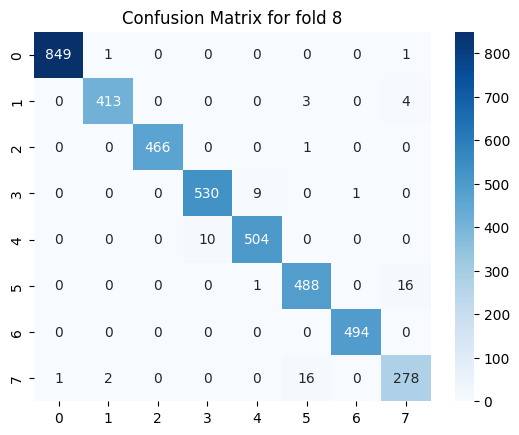


Evaluating fold 9...
Accuracy for fold 9: 0.9812
Classification report for fold 9:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       0.99      0.98      0.98       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.98      0.98       540
   Malayalam       0.97      0.98      0.98       513
     Marathi       0.94      0.97      0.96       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.95      0.91      0.93       297

    accuracy                           0.98      4088
   macro avg       0.98      0.98      0.98      4088
weighted avg       0.98      0.98      0.98      4088



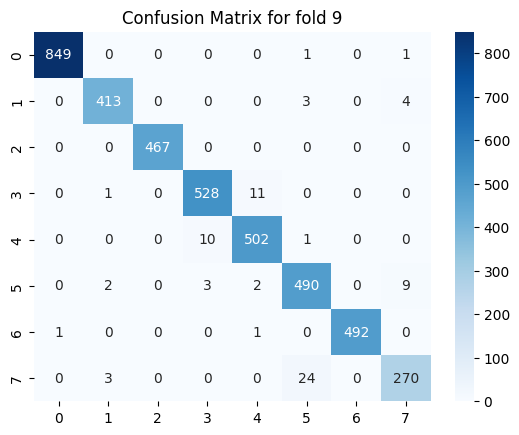


Evaluating fold 10...
Accuracy for fold 10: 0.9831
Classification report for fold 10:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       0.98      0.99      0.98       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.97      0.98       540
   Malayalam       0.97      0.99      0.98       513
     Marathi       0.95      0.97      0.96       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.96      0.91      0.93       296

    accuracy                           0.98      4087
   macro avg       0.98      0.98      0.98      4087
weighted avg       0.98      0.98      0.98      4087



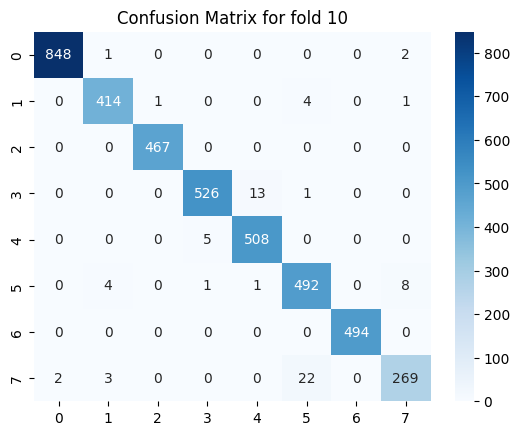


Mean accuracy across all folds: 0.9815

Evaluating Random Forest model...

Evaluating fold 1...
Accuracy for fold 1: 0.9917
Classification report for fold 1:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      0.99      0.99       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.99      0.98       541
   Malayalam       0.99      0.98      0.99       513
     Marathi       0.98      0.99      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.98      0.98      0.98       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



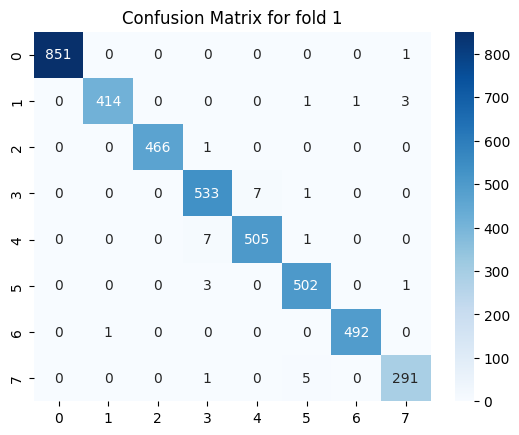


Evaluating fold 2...
Accuracy for fold 2: 0.9927
Classification report for fold 2:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      0.99      0.99       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.97      0.99      0.98       541
   Malayalam       0.99      0.98      0.98       513
     Marathi       0.99      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.99      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



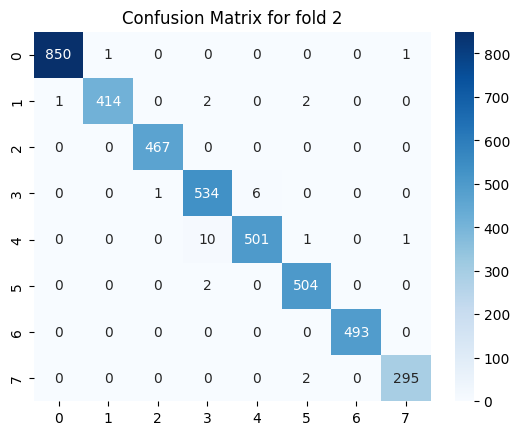


Evaluating fold 3...
Accuracy for fold 3: 0.9909
Classification report for fold 3:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       0.99      0.99      0.99       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.98      0.98       541
   Malayalam       0.99      0.98      0.99       513
     Marathi       0.98      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.98      0.98       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



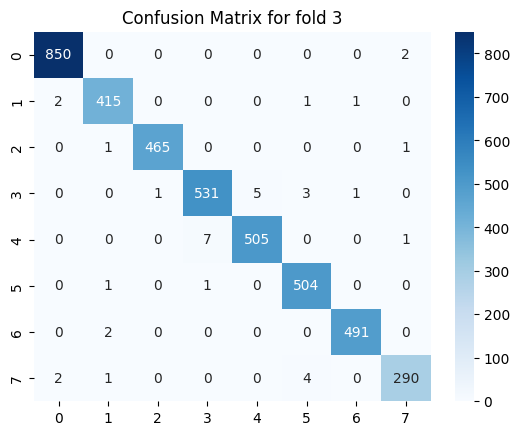


Evaluating fold 4...
Accuracy for fold 4: 0.9929
Classification report for fold 4:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       541
   Malayalam       0.99      0.98      0.99       513
     Marathi       0.99      0.99      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.98      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



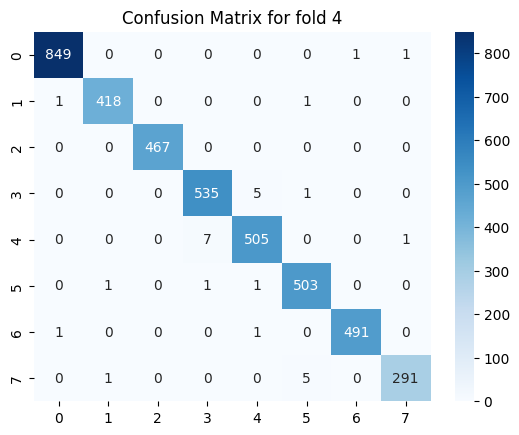


Evaluating fold 5...
Accuracy for fold 5: 0.9936
Classification report for fold 5:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.99      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.99      0.99       541
   Malayalam       0.99      0.98      0.98       513
     Marathi       0.99      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.99      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



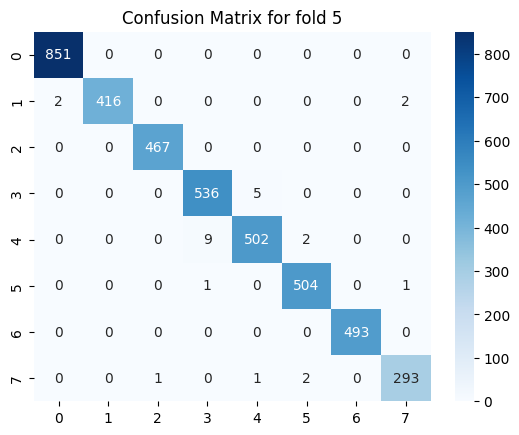


Evaluating fold 6...
Accuracy for fold 6: 0.9934
Classification report for fold 6:
              precision    recall  f1-score   support

    Assamese       0.99      1.00      1.00       851
     Bengali       1.00      0.99      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.99      0.99       541
   Malayalam       1.00      0.98      0.99       513
     Marathi       0.99      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       1.00      0.98      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



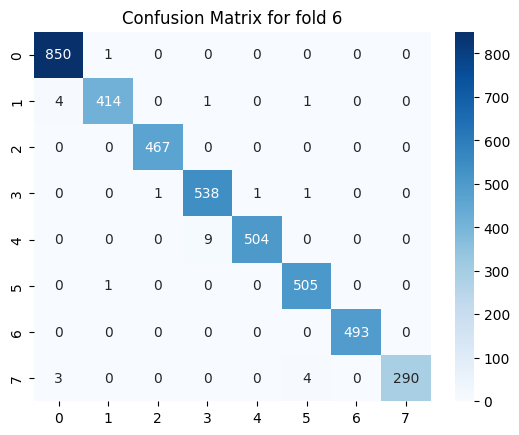


Evaluating fold 7...
Accuracy for fold 7: 0.9941
Classification report for fold 7:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.99      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       514
     Marathi       0.99      0.99      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.97      0.98       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



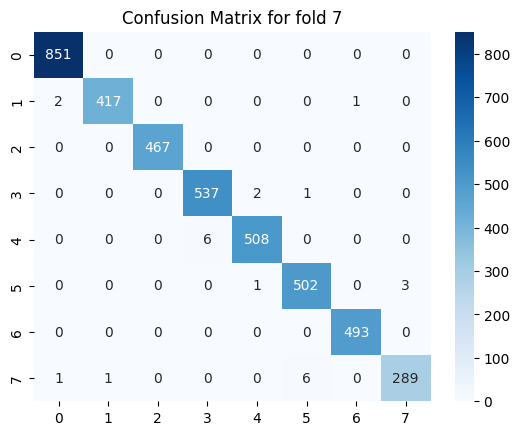


Evaluating fold 8...
Accuracy for fold 8: 0.9929
Classification report for fold 8:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       0.99      1.00      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.98      0.99       514
     Marathi       0.99      0.99      0.99       505
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.99      0.98      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



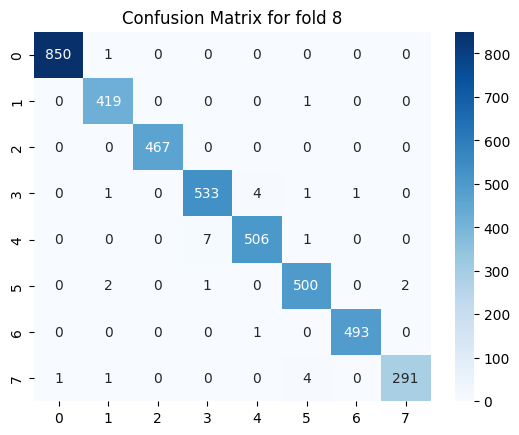


Evaluating fold 9...
Accuracy for fold 9: 0.9934
Classification report for fold 9:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.99      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       513
     Marathi       0.99      0.99      0.99       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.99      0.99      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



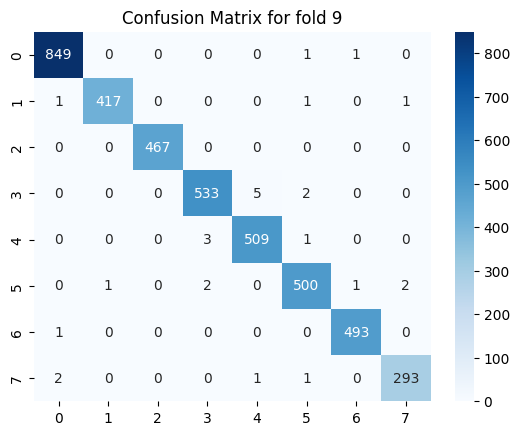


Evaluating fold 10...
Accuracy for fold 10: 0.9934
Classification report for fold 10:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       513
     Marathi       0.99      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.99      0.97      0.98       296

    accuracy                           0.99      4087
   macro avg       0.99      0.99      0.99      4087
weighted avg       0.99      0.99      0.99      4087



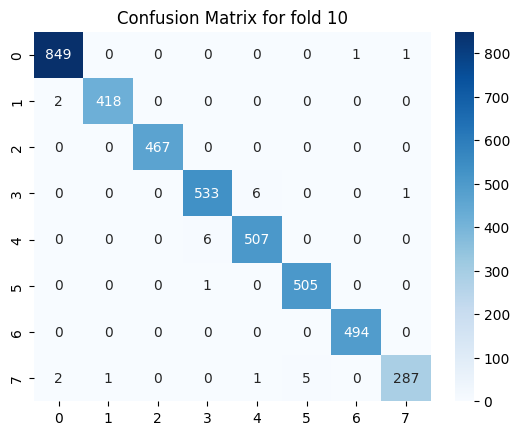


Mean accuracy across all folds: 0.9929

Evaluating Decision Tree model...

Evaluating fold 1...
Accuracy for fold 1: 0.9665
Classification report for fold 1:
              precision    recall  f1-score   support

    Assamese       0.98      0.98      0.98       852
     Bengali       0.98      0.96      0.97       419
     Gujrati       0.99      0.99      0.99       467
     Kannada       0.97      0.95      0.96       541
   Malayalam       0.96      0.97      0.96       513
     Marathi       0.96      0.97      0.97       506
  Rajasthani       0.96      0.97      0.96       493
      Telugu       0.89      0.92      0.90       297

    accuracy                           0.97      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.97      0.97      0.97      4088



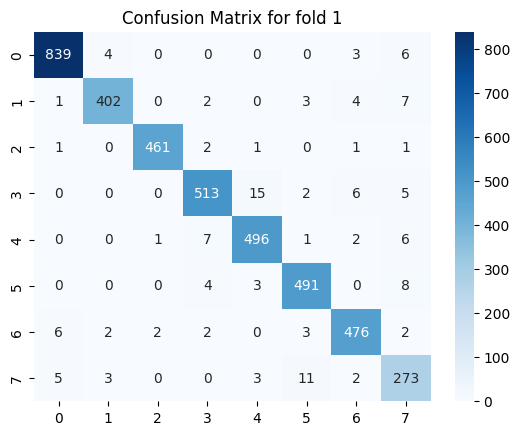


Evaluating fold 2...
Accuracy for fold 2: 0.9636
Classification report for fold 2:
              precision    recall  f1-score   support

    Assamese       0.98      0.99      0.99       852
     Bengali       0.96      0.96      0.96       419
     Gujrati       0.99      0.99      0.99       467
     Kannada       0.96      0.95      0.96       541
   Malayalam       0.95      0.97      0.96       513
     Marathi       0.94      0.94      0.94       506
  Rajasthani       0.97      0.97      0.97       493
      Telugu       0.92      0.92      0.92       297

    accuracy                           0.96      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.96      0.96      0.96      4088



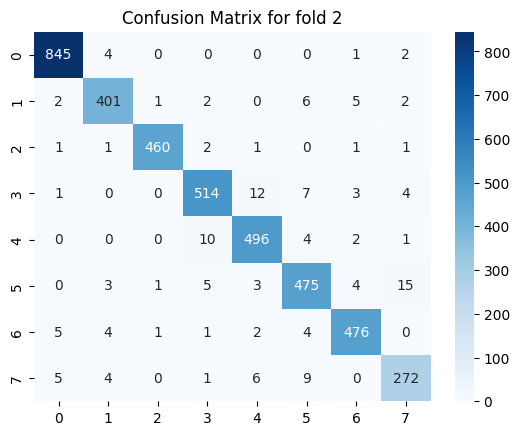


Evaluating fold 3...
Accuracy for fold 3: 0.9628
Classification report for fold 3:
              precision    recall  f1-score   support

    Assamese       0.98      0.99      0.99       852
     Bengali       0.96      0.96      0.96       419
     Gujrati       0.99      0.99      0.99       467
     Kannada       0.93      0.94      0.94       541
   Malayalam       0.95      0.95      0.95       513
     Marathi       0.95      0.96      0.96       506
  Rajasthani       0.97      0.96      0.96       493
      Telugu       0.96      0.92      0.94       297

    accuracy                           0.96      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.96      0.96      0.96      4088



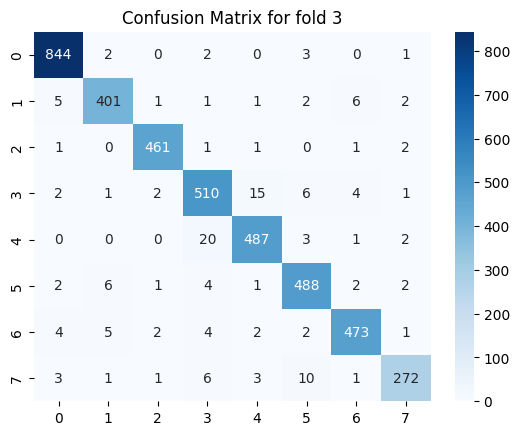


Evaluating fold 4...
Accuracy for fold 4: 0.9658
Classification report for fold 4:
              precision    recall  f1-score   support

    Assamese       0.99      0.99      0.99       851
     Bengali       0.96      0.95      0.95       420
     Gujrati       0.99      0.99      0.99       467
     Kannada       0.96      0.96      0.96       541
   Malayalam       0.96      0.96      0.96       513
     Marathi       0.96      0.95      0.95       506
  Rajasthani       0.97      0.97      0.97       493
      Telugu       0.90      0.92      0.91       297

    accuracy                           0.97      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.97      0.97      0.97      4088



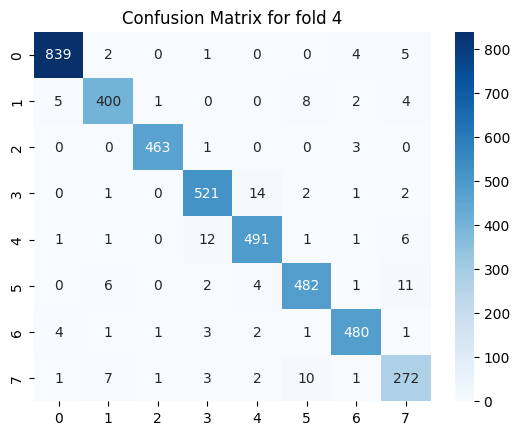


Evaluating fold 5...
Accuracy for fold 5: 0.9665
Classification report for fold 5:
              precision    recall  f1-score   support

    Assamese       0.99      0.99      0.99       851
     Bengali       0.97      0.95      0.96       420
     Gujrati       0.98      0.99      0.99       467
     Kannada       0.97      0.95      0.96       541
   Malayalam       0.96      0.96      0.96       513
     Marathi       0.96      0.94      0.95       506
  Rajasthani       0.97      0.98      0.97       493
      Telugu       0.91      0.95      0.93       297

    accuracy                           0.97      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.97      0.97      0.97      4088



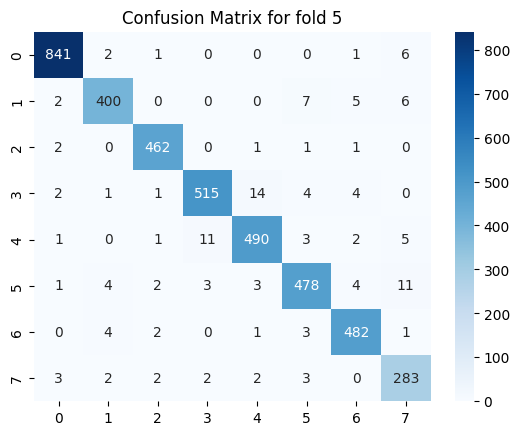


Evaluating fold 6...
Accuracy for fold 6: 0.9636
Classification report for fold 6:
              precision    recall  f1-score   support

    Assamese       0.99      0.98      0.98       851
     Bengali       0.96      0.95      0.95       420
     Gujrati       0.98      0.98      0.98       467
     Kannada       0.95      0.95      0.95       541
   Malayalam       0.96      0.95      0.96       513
     Marathi       0.95      0.96      0.96       506
  Rajasthani       0.98      0.97      0.97       493
      Telugu       0.90      0.94      0.92       297

    accuracy                           0.96      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.96      0.96      0.96      4088



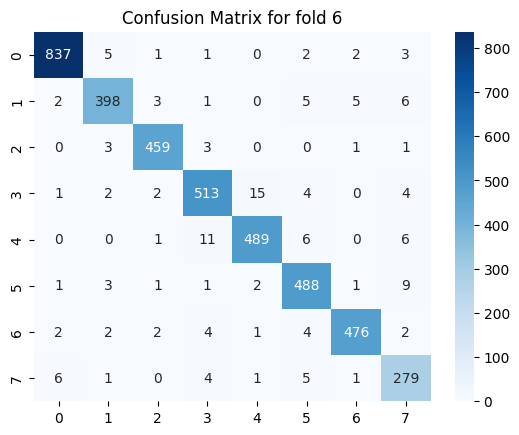


Evaluating fold 7...
Accuracy for fold 7: 0.9692
Classification report for fold 7:
              precision    recall  f1-score   support

    Assamese       0.98      0.99      0.99       851
     Bengali       0.97      0.97      0.97       420
     Gujrati       0.99      0.99      0.99       467
     Kannada       0.97      0.95      0.96       540
   Malayalam       0.95      0.98      0.96       514
     Marathi       0.96      0.96      0.96       506
  Rajasthani       0.98      0.97      0.98       493
      Telugu       0.93      0.92      0.92       297

    accuracy                           0.97      4088
   macro avg       0.97      0.96      0.97      4088
weighted avg       0.97      0.97      0.97      4088



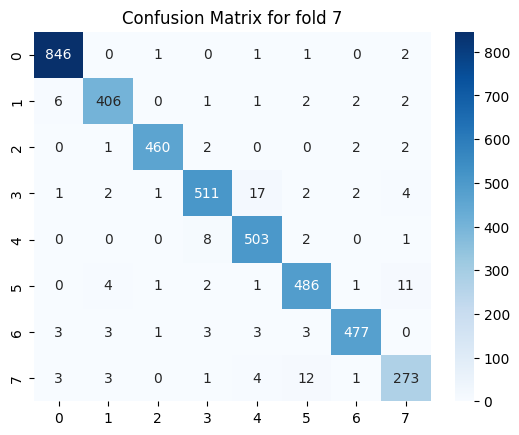


Evaluating fold 8...
Accuracy for fold 8: 0.9660
Classification report for fold 8:
              precision    recall  f1-score   support

    Assamese       0.99      0.98      0.99       851
     Bengali       0.95      0.96      0.96       420
     Gujrati       0.98      0.98      0.98       467
     Kannada       0.96      0.96      0.96       540
   Malayalam       0.97      0.96      0.96       514
     Marathi       0.95      0.96      0.95       505
  Rajasthani       0.97      0.96      0.97       494
      Telugu       0.92      0.94      0.93       297

    accuracy                           0.97      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.97      0.97      0.97      4088



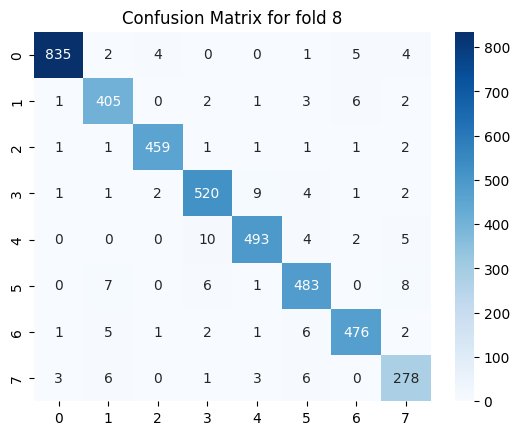


Evaluating fold 9...
Accuracy for fold 9: 0.9645
Classification report for fold 9:
              precision    recall  f1-score   support

    Assamese       0.98      0.99      0.99       851
     Bengali       0.97      0.95      0.96       420
     Gujrati       0.98      0.99      0.98       467
     Kannada       0.98      0.95      0.96       540
   Malayalam       0.95      0.97      0.96       513
     Marathi       0.94      0.94      0.94       506
  Rajasthani       0.96      0.97      0.96       494
      Telugu       0.92      0.92      0.92       297

    accuracy                           0.96      4088
   macro avg       0.96      0.96      0.96      4088
weighted avg       0.96      0.96      0.96      4088



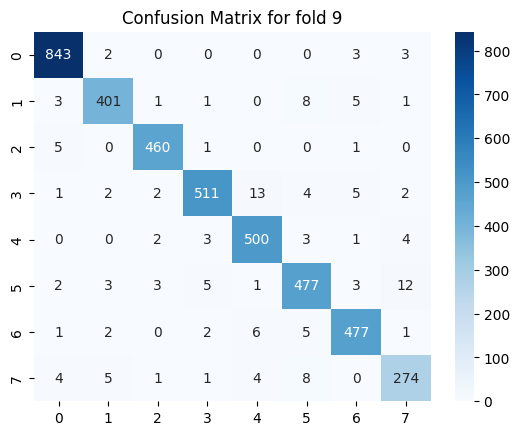


Evaluating fold 10...
Accuracy for fold 10: 0.9626
Classification report for fold 10:
              precision    recall  f1-score   support

    Assamese       0.98      0.99      0.99       851
     Bengali       0.95      0.96      0.96       420
     Gujrati       0.98      0.98      0.98       467
     Kannada       0.96      0.94      0.95       540
   Malayalam       0.94      0.96      0.95       513
     Marathi       0.96      0.97      0.96       506
  Rajasthani       0.97      0.97      0.97       494
      Telugu       0.91      0.90      0.91       296

    accuracy                           0.96      4087
   macro avg       0.96      0.96      0.96      4087
weighted avg       0.96      0.96      0.96      4087



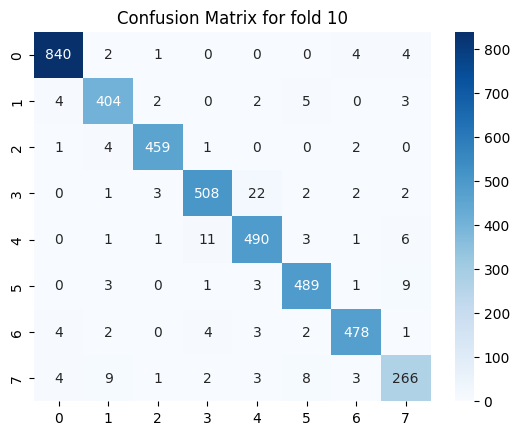


Mean accuracy across all folds: 0.9651

Evaluating XGBoost model...

Evaluating fold 1...
Accuracy for fold 1: 0.9939
Classification report for fold 1:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      0.99      1.00       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.99      0.99       541
   Malayalam       0.99      0.99      0.99       513
     Marathi       0.99      0.99      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.99      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



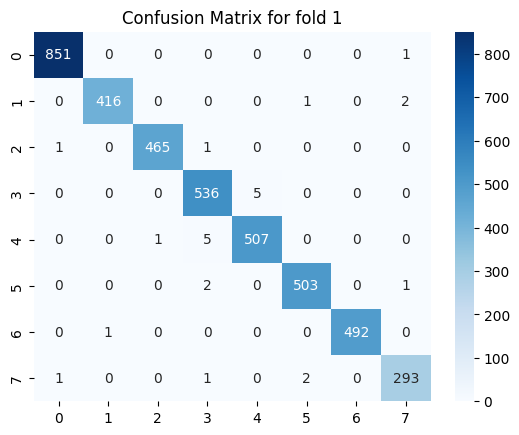


Evaluating fold 2...
Accuracy for fold 2: 0.9941
Classification report for fold 2:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       1.00      0.99      0.99       419
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.98      0.99      0.99       541
   Malayalam       0.99      0.98      0.99       513
     Marathi       0.99      0.99      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      1.00      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



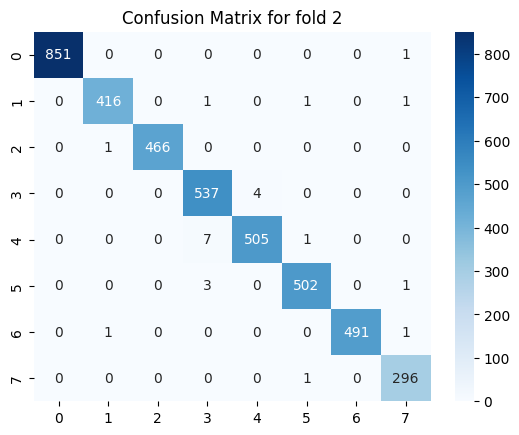


Evaluating fold 3...
Accuracy for fold 3: 0.9946
Classification report for fold 3:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       852
     Bengali       0.99      1.00      1.00       419
     Gujrati       1.00      0.99      1.00       467
     Kannada       0.99      0.99      0.99       541
   Malayalam       0.99      0.99      0.99       513
     Marathi       0.99      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.98      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



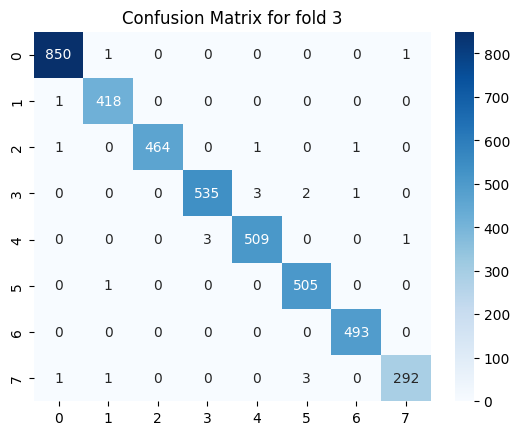


Evaluating fold 4...
Accuracy for fold 4: 0.9949
Classification report for fold 4:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       541
   Malayalam       0.99      0.98      0.99       513
     Marathi       0.99      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       1.00      0.99      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



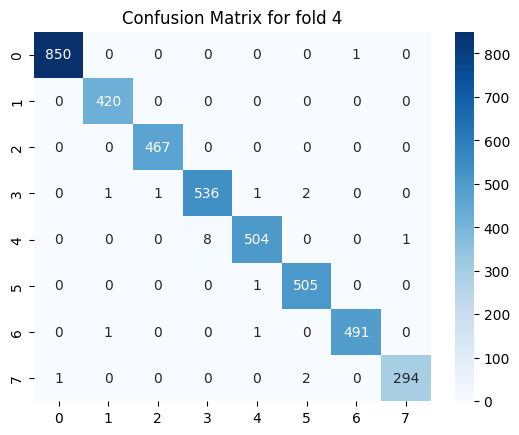


Evaluating fold 5...
Accuracy for fold 5: 0.9941
Classification report for fold 5:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.99      0.99       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       541
   Malayalam       0.98      0.99      0.98       513
     Marathi       0.99      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.99      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



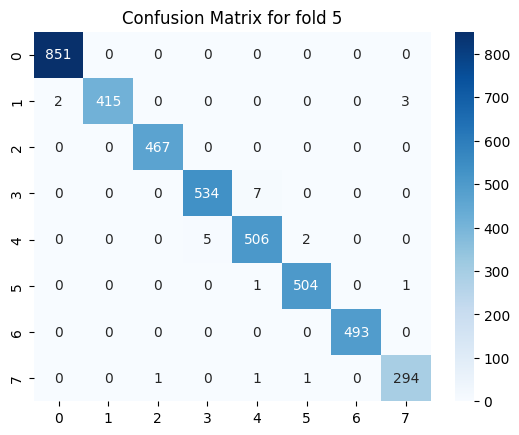


Evaluating fold 6...
Accuracy for fold 6: 0.9924
Classification report for fold 6:
              precision    recall  f1-score   support

    Assamese       0.99      1.00      1.00       851
     Bengali       0.99      0.98      0.99       420
     Gujrati       0.99      1.00      0.99       467
     Kannada       0.99      0.99      0.99       541
   Malayalam       1.00      0.98      0.99       513
     Marathi       0.98      1.00      0.99       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       0.99      0.98      0.98       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



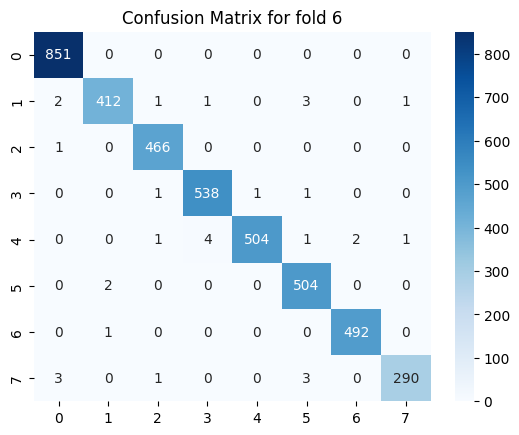


Evaluating fold 7...
Accuracy for fold 7: 0.9956
Classification report for fold 7:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       514
     Marathi       1.00      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       493
      Telugu       1.00      0.99      0.99       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



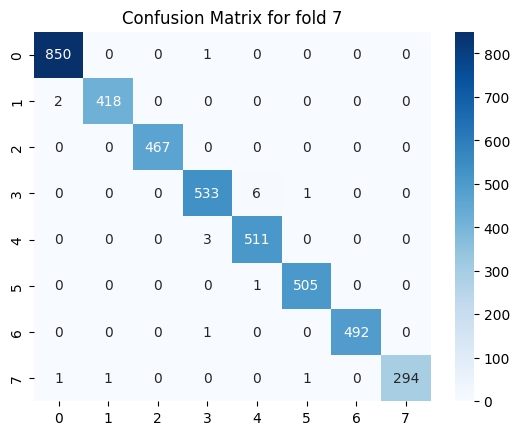


Evaluating fold 8...
Accuracy for fold 8: 0.9949
Classification report for fold 8:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       514
     Marathi       0.99      1.00      1.00       505
  Rajasthani       1.00      1.00      1.00       494
      Telugu       1.00      0.99      0.99       297

    accuracy                           0.99      4088
   macro avg       0.99      0.99      0.99      4088
weighted avg       0.99      0.99      0.99      4088



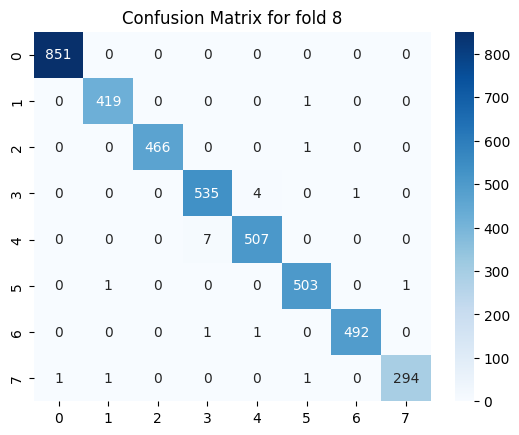


Evaluating fold 9...
Accuracy for fold 9: 0.9958
Classification report for fold 9:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      0.99      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      0.99      0.99       540
   Malayalam       0.99      0.99      0.99       513
     Marathi       1.00      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       0.99      1.00      0.99       297

    accuracy                           1.00      4088
   macro avg       1.00      1.00      1.00      4088
weighted avg       1.00      1.00      1.00      4088



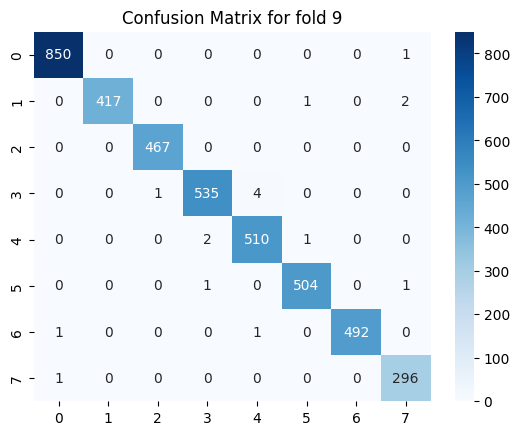


Evaluating fold 10...
Accuracy for fold 10: 0.9961
Classification report for fold 10:
              precision    recall  f1-score   support

    Assamese       1.00      1.00      1.00       851
     Bengali       1.00      1.00      1.00       420
     Gujrati       1.00      1.00      1.00       467
     Kannada       0.99      1.00      0.99       540
   Malayalam       0.99      0.99      0.99       513
     Marathi       0.99      1.00      1.00       506
  Rajasthani       1.00      1.00      1.00       494
      Telugu       1.00      0.98      0.99       296

    accuracy                           1.00      4087
   macro avg       1.00      1.00      1.00      4087
weighted avg       1.00      1.00      1.00      4087



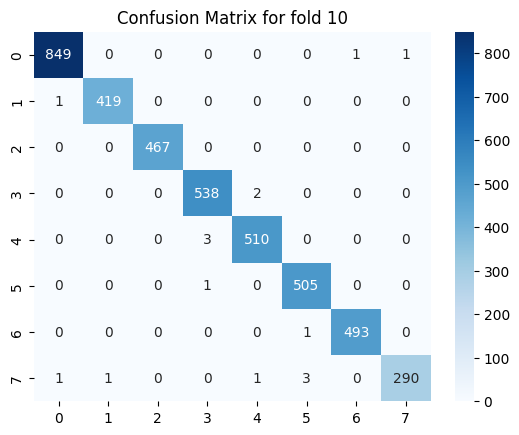


Mean accuracy across all folds: 0.9946


In [11]:
# Initialize k-fold cross-validation with stratification
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate each model using a pipeline to avoid data leakage
for name, model in models.items():
    print(f"\nEvaluating {name} model...")
    
    # Create a pipeline for each model
    model_pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Scaling inside the pipeline
        ('pca', PCA(n_components=10)),  # Optional: Include PCA if dimensionality reduction is needed
        ('model', model)  # Model goes here
    ])
    
    evaluate_model(model_pipeline, X_scaled, y_encoded, kf)
